## Preamble

In [1]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds/'

# set path as working directory:
os.chdir(path)

In [3]:
# Load legacy data
rcfd_legacy = pd.read_csv(path+'/legacy/RCFD_legacy.csv')
#rcfn_legacy = pd.read_csv(path+'/legacy/RCFN_legacy.csv')
rcon_legacy = pd.read_csv(path+'/legacy/RCON_legacy.csv')
riad_legacy = pd.read_csv(path+'/legacy/RIAD_legacy.csv')

In [4]:
rcfd_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

riad_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcon_legacy.rename(columns={'RSSD9999':'Date', 'RSSD9010': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

In [5]:
rcfd_legacy['Date'] = pd.to_datetime(rcfd_legacy['Date'], format='%Y%m%d')
riad_legacy['Date'] = pd.to_datetime(riad_legacy['Date'], format='%Y%m%d')
rcon_legacy['Date'] = pd.to_datetime(rcon_legacy['Date'], format='%Y%m%d')

In [6]:
# Load newer data
rcfd = pd.read_csv(path+'/newer/RCFD.csv')
rcfa = pd.read_csv(path+'/newer/RCFA.csv')
rcfn = pd.read_csv(path+'/newer/RCFN.csv')
rcon = pd.read_csv(path+'/newer/RCON.csv')
riad = pd.read_csv(path+'/newer/RIAD.csv')

In [7]:
# Rename column RSSD9999 to Date:
rcfd.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcfa.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcfn.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

rcon.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

riad.rename(columns={'RSSD9999':'Date', 'RSSD9017': 'Financial Institution Name', 
                     'RSSD9001': 'IDRSSD'}, inplace=True)

In [8]:
riad['Date'] = pd.to_datetime(riad['Date'], format='%Y-%m-%d')
rcfd['Date'] = pd.to_datetime(rcfd['Date'], format='%Y-%m-%d')
rcfa['Date'] = pd.to_datetime(rcfa['Date'], format='%Y-%m-%d')
rcfn['Date'] = pd.to_datetime(rcfn['Date'], format='%Y-%m-%d')
rcon['Date'] = pd.to_datetime(rcon['Date'], format='%Y-%m-%d')

In [9]:
# put NaN instead of zeros in rcon and rcon_legacy:
rcon['RCON2122'] = rcon['RCON2122'].replace(0, np.nan)
rcon_legacy['RCON2122'] = rcon_legacy['RCON2122'].replace(0, np.nan)

## Merging Loans

In [10]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_rcon = pd.merge(rcon_legacy[['Date', 'IDRSSD', 'RCON2122', 'RCON1400']], 
                     rcon[['Date', 'Financial Institution Name', 'IDRSSD', 'RCON2122']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')
# take the difference between RCON2122_new and RCON2122_legacy:
df_rcon['Difference'] = df_rcon['RCON2122_new'] - df_rcon['RCON2122_legacy']

# exclude the last date:
df_rcon = df_rcon[df_rcon['Date']<df_rcon['Date'].max()]

Note that even for the Dates that _legacy_ and _newer_ RCON series coincide, we have a discrepancies between the those two.  

In [11]:
df_rcon = df_rcon[['Date', 'IDRSSD', 'Financial Institution Name', 'RCON2122_legacy', 'RCON2122_new', 'Difference']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_rcon['Flag'] = np.where(df_rcon['Difference'] == 0, 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_rcon['Flag'] = np.where(df_rcon['RCON2122_legacy'].isna() | df_rcon['RCON2122_new'].isna(), 0, df_rcon['Flag'])

In [12]:
df_rcon['RCON2122'] = df_rcon['RCON2122_new'].fillna(df_rcon['RCON2122_legacy'])

In [13]:
# exclude observations made in moments different than quarter ends:
df_rcon = df_rcon[df_rcon['Date'].dt.month.isin([3, 6, 9, 12])]

#date_min = df_rcon.groupby('Date')['RCON2122'].sum()==df_rcon.groupby('Date')['RCON2122'].sum().min()
#df_rcon[df_rcon['Date'].isin(date_min[date_min].index)]

In [15]:
# Step 1: Identify the total number of unique dates
total_dates = df_rcon['Date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_rcon.groupby('IDRSSD')['Date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

In [16]:
# drop observations from the last 'Date':
balanced_rcon = df_rcon[df_rcon['IDRSSD'].isin(balanced_banks_list)]

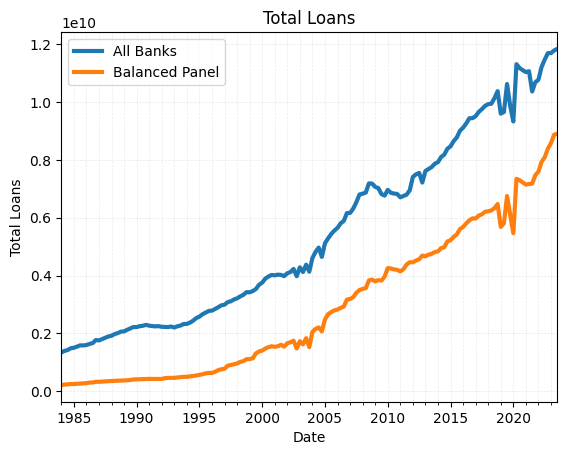

In [17]:
# sum 'Loans' by 'Date' and plot the time series:
df_rcon[df_rcon['Flag']==0].groupby('Date')['RCON2122'].sum().plot(linewidth=3)
balanced_rcon[balanced_rcon['Flag']==0].groupby('Date')['RCON2122'].sum().plot(linewidth=3)
plt.title('Total Loans')
plt.xlabel('Date')
plt.ylabel('Total Loans')
plt.legend(['All Banks', 'Balanced Panel'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [18]:
# export the balanced panel to a csv file:
balanced_rcon.to_csv(path+'/loans_balanced_panel.csv', index=False)
df_rcon.to_csv(path+'/loans_unbalanced.csv', index=False)

## Merging Interest Rate Income

In [56]:
# show me the dates in rcon_legacy where 'RCON2122' and 'RCON1400' are not NaN:
df_riad = pd.merge(riad_legacy[['Date', 'IDRSSD', 'RIAD4010', 'RIAD4065']], 
                     riad[['Date', 'IDRSSD', 'Financial Institution Name', 'RIAD4010', 'RIAD4065']],
                        on=['Date', 'IDRSSD'], suffixes=('_legacy', '_new'), how='outer')

df_riad['Difference 4010'] = df_riad['RIAD4010_new'] - df_riad['RIAD4010_legacy']
df_riad['Difference 4065'] = df_riad['RIAD4065_new'] - df_riad['RIAD4065_legacy']

# exclude the last date:
df_riad = df_riad[df_riad['Date']<df_riad['Date'].max()]

In [57]:
df_riad = df_riad[['Date', 'IDRSSD', 'Financial Institution Name', 'RIAD4010_legacy', 'RIAD4010_new',
                    'RIAD4065_legacy', 'RIAD4065_new', 'Difference 4010', 'Difference 4065']]

# create a 'Flag' colum that takes the value zero if the difference is zero:
df_riad['Flag'] = np.where((df_riad['Difference 4010'] == 0) & (df_riad['Difference 4065']==0), 0, 1)

# let flag to be zero in places where either RCON2122_legacy or RCON2122_new is NaN:
df_riad['Flag'] = np.where(df_riad['Difference 4010'].isna() | df_riad['Difference 4065'].isna(), 0, df_riad['Flag'])

In [59]:
df_riad['Aux'] = (df_riad['RIAD4010_new']+
                                df_riad['RIAD4065_new']).fillna(df_riad['RIAD4010_legacy']+df_riad['RIAD4065_legacy'])

df_riad['Int. Income Loans'] = df_riad.groupby(['IDRSSD', df_riad['Date'].dt.year])['Aux'].diff().fillna(df_riad['Aux'])

In [60]:
df_riad = df_riad[['Date', 'IDRSSD', 'Financial Institution Name', 'Int. Income Loans', 'Flag']]

In [62]:
# exclude observations made in moments different than quarter ends:
df_riad = df_riad[df_riad['Date'].dt.month.isin([3, 6, 9, 12])]

In [ ]:
# Step 1: Identify the total number of unique dates
total_dates = df_riad['Date'].nunique()

# Step 2: Count the number of unique dates per bank
bank_date_counts = df_riad.groupby('IDRSSD')['Date'].nunique()

# Step 3: Filter banks with observations for all dates
balanced_banks = bank_date_counts[bank_date_counts == total_dates].index

# Step 4: Save the list of IDRSSD
balanced_banks_list = balanced_banks.tolist()

# drop observations from the last 'Date':
balanced_riad = df_riad[df_riad['IDRSSD'].isin(balanced_banks_list)]

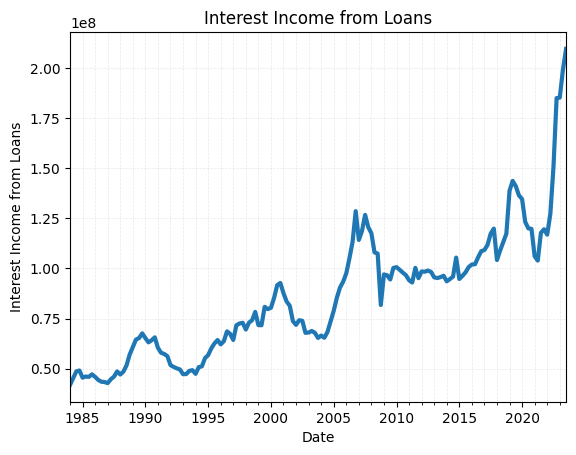

In [63]:
df_riad[df_riad['Flag']==0].groupby('Date')['Int. Income Loans'].sum().plot(linewidth=3)
plt.title('Interest Income from Loans')
plt.xlabel('Date')
plt.ylabel('Interest Income from Loans')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgrey')
plt.show()

## Testing Assets

In [ ]:
# Compute the difference between the 
legacy_df['Difference Assets'] = legacy_df['RCFD2170'] - legacy_df['RCON2170'] 
legacy_df['Difference Assets (%)'] = legacy_df['Difference Assets']/legacy_df['RCFD2170']*100
legacy_df[(legacy_df['IDRSSD']==480228) & (legacy_df['Date'].dt.year>2008)
          & (legacy_df['Date'].dt.year<2023)][['Date', 'Financial Institution Name', 'RCFD2170', 'RCON2170', 'Difference Assets', 'Difference Assets (%)']]

In [ ]:
# do the same for newer data:
newer_df['Difference Assets'] = newer_df['RCFD2170'] - newer_df['RCON2170']
newer_df['Difference Assets (%)'] = newer_df['Difference Assets']/newer_df['RCFD2170']
newer_df[(newer_df['IDRSSD']==37) & (newer_df['Date'].dt.year>2011)
          & (newer_df['Date'].dt.year<2024)][['Date', 'Financial Institution Name', 'RCFD2170', 'RCON2170', 'Difference Assets', 'Difference Assets (%)']]

## Testing Loans

### Loan amounts

In [ ]:
# Compute the difference
legacy_df['Difference Loans'] = legacy_df['RCFD1400'] - legacy_df['RCON1400'] 
legacy_df['Difference Loans (%)'] = legacy_df['Difference Loans']/legacy_df['RCFD1400']*100
legacy_df[(legacy_df['IDRSSD']==480228) #& (legacy_df['Date'].dt.year>2000) & (legacy_df['Date'].dt.year<2011)
          & (legacy_df['Date'].dt.year<2002)][['Date', 'Financial Institution Name', 'RCFD1400', 'RCON1400', 'Difference Loans', 'Difference Loans (%)']]

In [ ]:
# Compute the difference between the 
newer_df['Difference Loans'] = newer_df['RCFD2122'] - newer_df['RCON2122'] 
newer_df['Difference Loans (%)'] = newer_df['Difference Loans']/newer_df['RCFD2122']*100
newer_df[(newer_df['IDRSSD']==480228) & (newer_df['Date'].dt.year>2000)
          & (newer_df['Date'].dt.year<2011)][['Date', 'Financial Institution Name', 'RCFD2122', 'RCON2122', 'Difference Loans', 'Difference Loans (%)']]

### Income from loans

In [ ]:
riad_legacy[(riad_legacy['IDRSSD']==480228) & 
            (riad_legacy['Date'].dt.year>2000)][['Date', 'Financial Institution Name', 'RIAD4010', 'RIAD4065', 'RIAD4059']]

In [ ]:
riad[riad['IDRSSD']==480228][['Date', 'Financial Institution Name', 'RIAD4010', 'RIAD4065', 'RIAD4059']]

## Testing Deposits

In [ ]:
# Compute the difference
legacy_df['Difference Deposits'] = legacy_df['RCFD2200'] - legacy_df['RCON2200'] 
legacy_df['Difference Deposits (%)'] = legacy_df['Difference Deposits']/legacy_df['RCFD1400']*100
legacy_df[(legacy_df['IDRSSD']==480228) & (legacy_df['Date'].dt.year>2008)
          & (legacy_df['Date'].dt.year<2016)][['Date', 'Financial Institution Name', 'RCFD2200', 'RCON2200', 'Difference Deposits', 'Difference Deposits (%)']]

In [ ]:
newer_df2 = pd.merge(newer_df, rcfn, on=['Date', 'IDRSSD', 'Financial Institution Name'], how='outer')

In [ ]:
# do the same for newer data:
newer_df2['Total Deposits'] = newer_df2['RCON2200']+newer_df2['RCFN2200']
newer_df2['Difference Deposits (%)'] = newer_df2['RCFN2200'] / newer_df2['Total Deposits']*100
newer_df2[(newer_df2['IDRSSD']==480228) & (newer_df2['Date'].dt.year>2008)
          & (newer_df2['Date'].dt.year<2024)][['Date', 'Financial Institution Name', 'Total Deposits', 'RCON2200', 'RCFN2200', 'Difference Deposits (%)']]

## Testing FedFunds Purchased

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year<2002)][['Date', 'Financial Institution Name', 'RCFD2800']]

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>2001)][['Date', 'Financial Institution Name', 'RCFDB993', 'RCFDB995']]

In [ ]:
rcfd[(rcfd['IDRSSD']==802866) ][['Date', 'Financial Institution Name', 'RCFDB993', 'RCFDB995']]

## Testing Loans Non-Accrual

In [ ]:
rcfd[(rcfd['IDRSSD']==480228)][['Date', 'Financial Institution Name', 'RCFD1403']]

In [ ]:
rcfd[(rcfd['IDRSSD']==802866)][['Date', 'Financial Institution Name', 'RCFD1403']]

## Test Loans Past Due 90 Days

In [ ]:
rcfd[(rcfd['IDRSSD']==802866)][['Date', 'Financial Institution Name', 'RCFD1407']]

In [ ]:
rcfd[(rcfd['IDRSSD']==480228)][['Date', 'Financial Institution Name', 'RCFD1407']]

## Testing Tier 1 Capital

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>1995) 
                              & (rcfd['Date'].dt.year<2015)][['Date', 'Financial Institution Name','RCFD8274']]

In [ ]:
rcfa[(rcfa['IDRSSD']==480228) & (rcfa['Date'].dt.year>2013)][['Date', 'Financial Institution Name','RCFA8274']]

In [ ]:
rcfd[(rcfd['IDRSSD']==802866) & (rcfd['Date'].dt.year>1995) 
                              & (rcfd['Date'].dt.year<2016)][['Date', 'Financial Institution Name','RCFD8274']]

In [ ]:
rcfa[(rcfa['IDRSSD']==802866) & (rcfa['Date'].dt.year>2013)][['Date', 'Financial Institution Name','RCFA8274']]

## Testing Risk-Weighted Assets

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>1995) 
                              & (rcfd['Date'].dt.year<2016)][['Date', 'Financial Institution Name','RCFDA223']]

In [ ]:
rcfa[(rcfa['IDRSSD']==480228) & (rcfa['Date'].dt.year>2013)][['Date', 'Financial Institution Name','RCFAA223']]

In [ ]:
rcfd[(rcfd['IDRSSD']==802866) & (rcfd['Date'].dt.year>1995) 
                              & (rcfd['Date'].dt.year<2016)][['Date', 'Financial Institution Name','RCFDA223']]

In [ ]:
rcfa[(rcfa['IDRSSD']==802866) & (rcfa['Date'].dt.year>2013)][['Date', 'Financial Institution Name','RCFAA223']]

## Testing Other Borrowings

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>1984) 
                              & (rcfd['Date'].dt.year<2002)][['Date', 'Financial Institution Name','RCFD2835', 'RCFD3190']]

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>2002)][['Date', 'Financial Institution Name','RCFD2835', 'RCFD3190']]

## Testing Cash

In [ ]:
rcfd[(rcfd['IDRSSD']==480228)][['Date', 'Financial Institution Name','RCFD0010']]

In [ ]:
rcfd[(rcfd['IDRSSD']==802866)][['Date', 'Financial Institution Name','RCFD0010']]

## Testing Federal Funds Sold

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>1983) 
                              & (rcfd['Date'].dt.year<2003)][['Date', 'Financial Institution Name','RCFD1350']]

In [ ]:
rcfd[(rcfd['IDRSSD']==480228) & (rcfd['Date'].dt.year>2001)][['Date', 'Financial Institution Name','RCFDB987', 'RCFDB989']]

## Dean's Variables

In [ ]:
# concatenate the two dataframes:
df = pd.merge(riad, rcfd, on=['Date', 'IDRSSD', 'Financial Institution Name'], how='outer')
df = pd.merge(df, rcfa, on=['Date', 'IDRSSD', 'Financial Institution Name'], how='outer')

In [ ]:
# create a 'Year' column:
df['Year'] = df['Date'].dt.year

# create a 'Quarter' column:
df['Quarter'] = df['Date'].dt.quarter

In [ ]:
df.rename(columns={ # RCFD variables (Balance Sheet):
                'RCFD2170':'Total Assets', 'RCFD1400': 'Loans', 'RCFD2200': 'Deposits', 
                'RCFD1403': 'Loans Non-Accrual', 'RCFD1407':'Loans Past Due 90 Days',
                'RCFD0010': 'Cash', 
                # RIAD variables (Income Statement):
                'RIAD4170':'Interest Exp. Deposits', 
                'RIAD4180': 'Interest Exp. FedFunds', 'RIAD4635': 'Charge Off Loans', 
                'RIAD4605': 'Recovery Loans', 'RIAD4130': 'Total Expenses', 
                'RIAD4217': 'Expenses on premises and fixed assets', 
                'RIAD4135': 'Labor expenses', 'RIAD4079': 'Total Non-interest Income'}, inplace=True)

In [ ]:
df['Interest Income Loans'] = df['RIAD4010'].fillna(0)+df['RIAD4065'].fillna(0)
df['Dividends'] = df['RIAD4470'].fillna(0)+df['RIAD4460'].fillna(0)

In [ ]:
df['Federal Funds Purchased'] = np.where(df['Date'].dt.year < 2002, df['RCFD2800'], df['RCFDB993']+df['RCFDB995'])
df['Tier 1 Capital'] = np.where(df['Date'].dt.year < 2014, df['RCFD8274'], df['RCFA8274'])
df['Risk-Weighted Assets'] = np.where(df['Date'].dt.year < 2014, df['RCFDA223'], df['RCFAA223'])
df['Other Borrowings'] = np.where(df['Date'].dt.year < 2001, df['RCFD2835'], df['RCFD3190'])
df['FedFunds Sold'] = np.where(df['Date'].dt.year < 2002, df['RCFD1350'], df['RCFDB987']+df['RCFDB989'])
df['US Treasury Securities'] = np.where(df['Date'].dt.year < 1994, df['RCFD0400'], df['RCFD0211']+df['RCFD1287'])

In [ ]:
# For 'US Agency Obligations' we need a np.where with 3 time windows (1984-1993, 1994-2008, 2009-2010, 2011-2021):
df['US Agency Obligations'] = np.where(
                            df['Date'].dt.year < 1994, df['RCFD0600'],
                            np.where(
                            df['Date'].dt.year < 2009, 
                            df['RCFD1289'].fillna(0)+df['RCFD1294'].fillna(0)+df['RCFD1293'].fillna(0)+df['RCFD1298'].fillna(0)+
                            df['RCFD1698'].fillna(0)+df['RCFD1702'].fillna(0)+df['RCFD1703'].fillna(0)+df['RCFD1707'].fillna(0)+
                            df['RCFD1714'].fillna(0)+df['RCFD1717'].fillna(0)+df['RCFD1718'].fillna(0)+df['RCFD1732'].fillna(0),
                            np.where(
                            df['Date'].dt.year < 2011, 
                            df['RCFD1289'].fillna(0)+df['RCFD1294'].fillna(0)+df['RCFD1293'].fillna(0)+df['RCFD1298'].fillna(0)+
                            df['RCFDG300'].fillna(0)+df['RCFDG303'].fillna(0)+df['RCFDG304'].fillna(0)+df['RCFDG307'].fillna(0)+
                            df['RCFDG312'].fillna(0)+df['RCFDG315'].fillna(0)+df['RCFDG316'].fillna(0)+df['RCFDG319'].fillna(0)+
                            df['RCFDG324'].fillna(0)+df['RCFDG327'].fillna(0),
                            df['RCFD1289'].fillna(0)+df['RCFD1294'].fillna(0)+df['RCFD1293'].fillna(0)+df['RCFD1298'].fillna(0)+
                            df['RCFDG300'].fillna(0)+df['RCFDG303'].fillna(0)+df['RCFDG304'].fillna(0)+df['RCFDG307'].fillna(0)+
                            df['RCFDG312'].fillna(0)+df['RCFDG315'].fillna(0)+df['RCFDG316'].fillna(0)+df['RCFDG319'].fillna(0) 
# Missing here RCFDK142 and RCFDK145.
                            )
                            )
)

In [ ]:
df['Interest Income Safe Securities'] = np.where(df['Date'].dt.year<2001, df['RIAD4027'], df['RIADB488'])
df['Equity Issuance'] = np.where(df['Date'].dt.year<2001, df['RIAD4346'].fillna(0)+df['RIADB510'].fillna(0), 
                                 df['RIADB509'].fillna(0)+df['RIADB510'].fillna(0))

In [ ]:
# Derived variables:
df['Loans (RW Assets) to Assets'] = df['Risk-Weighted Assets']/df['Total Assets']
df['Cash and Securities to Assets'] = 1 - df['Loans (RW Assets) to Assets']
df['Capital Ratio (risk-weighted)'] = df['Tier 1 Capital']/df['Risk-Weighted Assets']
df['Equity to Assets'] = df['Tier 1 Capital']/df['Total Assets']
df['Deposits to Assets'] = 1 - df['Equity to Assets']
df['Interest Return on Loans'] = df['Interest Income Loans']/df['Loans']
df['Interest Cost Deposits'] = df['Interest Exp. Deposits']/df['Deposits']
df['Loan Interest Margin'] = df['Interest Income Loans']-df['Interest Exp. Deposits']
df['Cost Fed Funds'] = df['Interest Exp. FedFunds']/df['Federal Funds Purchased']
df['Charge Off Rate Loans']  = (df['Charge Off Loans']-df['Recovery Loans'])/df['Loans']
df['Delinquency Rate Loans'] = (df['Loans Non-Accrual']+df['Loans Past Due 90 Days'])/df['Loans']
df['Safe Securities'] = df['US Treasury Securities']+df['US Agency Obligations']
df['Cost of Funds'] = (df['Interest Exp. Deposits']+df['Interest Exp. FedFunds'])/(df['Deposits']+df['Federal Funds Purchased'])
df['Interest Return on Safe Assets'] = df['Interest Income Safe Securities'] / df['Safe Securities']
df['Return Safe Securities'] = df['Interest Return on Safe Assets'] - df['Cost of Funds']
df['Return on Loans'] = df['Interest Return on Loans'] - df['Charge Off Rate Loans']

In [ ]:
# keep only the variables we created/renamed:
df = df[['Date', 'Year', 'Quarter', 'Financial Institution Name', 'IDRSSD', 'Total Assets', 'Loans', 'Deposits', 
         'Loans Non-Accrual', 'Loans Past Due 90 Days', 'Cash', 'Interest Income Loans', 'Dividends', 
         'Interest Exp. Deposits', 'Interest Exp. FedFunds', 'Charge Off Loans', 'Recovery Loans', 
         'Total Expenses', 'Expenses on premises and fixed assets', 'Labor expenses', 'Total Non-interest Income', 
         'Federal Funds Purchased', 'Tier 1 Capital', 'Risk-Weighted Assets', 'Other Borrowings', 'FedFunds Sold', 
         'US Treasury Securities', 'US Agency Obligations', 'Interest Income Safe Securities', 'Equity Issuance', 
         'Loans (RW Assets) to Assets', 'Cash and Securities to Assets', 'Capital Ratio (risk-weighted)', 
         'Equity to Assets', 'Deposits to Assets', 'Interest Return on Loans', 'Interest Cost Deposits', 
         'Loan Interest Margin', 'Cost Fed Funds', 'Charge Off Rate Loans', 'Delinquency Rate Loans', 
         'Safe Securities', 'Cost of Funds', 'Interest Return on Safe Assets', 'Return Safe Securities', 
         'Return on Loans']]

Recall that plenty of the variables computed here are ratios. So if some banks have a zero for the denominator, those ratios would explode. 

## M&A Merges

In [ ]:
df2 = df.copy()

In [ ]:
transformations = pd.read_csv('C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean/CSV_TRANSFORMATIONS.csv')

transformations['DT_TRANS'] = transformations['DT_TRANS'].astype(str)

transformations['Year'] = transformations['DT_TRANS'].str[:4]
transformations['Month'] = transformations['DT_TRANS'].str[4:6]
transformations['Day'] = transformations['DT_TRANS'].str[6:8]
transformations['Transaction Date'] = pd.to_datetime(transformations['Year'] + '-' + transformations['Month'] + '-' + transformations['Day'])

# drop the Month, Day, and Year columns:
transformations.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Rename #ID_RSSD_PREDECESSOR to IDRSSD Predecessor:
transformations.rename(columns={'#ID_RSSD_PREDECESSOR':'IDRSSD Predecessor',
                                'ID_RSSD_SUCCESSOR': 'IDRSSD Successor', 
                                'TRNSFM_CD': 'Transformation Code'}, inplace=True)

# make those columns integers:
transformations['IDRSSD Predecessor'] = transformations['IDRSSD Predecessor'].astype(int)
transformations['IDRSSD Successor'] = transformations['IDRSSD Successor'].astype(int)

transformations = transformations[['Transaction Date', 'IDRSSD Predecessor', 'IDRSSD Successor', 'Transformation Code']]


In [ ]:
df_predecessor = pd.merge(df2, transformations, left_on='IDRSSD', right_on='IDRSSD Predecessor', how='left')
df_successor = pd.merge(df2, transformations, left_on='IDRSSD', right_on='IDRSSD Successor', how='left')